## **Classification - how to recognize one user among all others**

# Introduction

This dataset contains user transitions between pages. The goal of this challenge is to recognize one user among all others. The dataset consists of user sessions, each session is a sequence of transitions between pages. A sequence can be one to ten pages long.

The notebook created by https://github.com/sergevv/

### Dataset description

train.csv - webpages, timestamps, and targets for each train session.

id_map.parquet - webpages id to url map

source: https://www.kaggle.com/competitions/epamdscourseclassification3/data

### Attribute Information

Feature | Description | Format
--- | --- | ---
webpage1 ... webpage10 | id of website for 1 ... 10 session | nubmer from 165 to 540965
time1 ... time10 | start time of 1 ... 10 session | yyyy-mm-dd hh:mm:ss (after formating)
target | target user we are looking for | 1 or 0

.

# **1. Import Data**

### 1.1. Import libraries



In [290]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from IPython.display import HTML
import base64

In [291]:
!pip install -U -q catboost
from catboost import CatBoostClassifier

!pip install -U -q tldextract
import tldextract # https://pypi.org/project/tldextract/

.

### 1.2. Functions

In [292]:
# Function HEATMAP for missing data (NaN) in dataframes

def heatmap_missing_df(df):

    font_size = 12
    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    cmap = sns.diverging_palette(20, 275, s=80, as_cmap=True)

    sns.heatmap(df.isna(), cmap='plasma', cbar = False, yticklabels=False)

    plt.xticks(fontsize=font_size, rotation=45)
    axes.set_title("Missing values heatmap", fontsize=font_size+4)
    axes.tick_params(axis='y', length=0)

In [293]:
# Function for converting categorical data in columns to 0/1 (analogue of OneHotEncoding)

def categor_get_dummies(df, column):
    dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummy], axis=1).drop(column, axis=1)
    return df

In [294]:
def min_max_scaling(column, web_max, web_min):
    return (column - web_min) / (web_max - web_min)

In [295]:
# Function for creating new features from old ones (for TRAIN dataset)

def dataset_processing (df):

    df = df.assign(duration_sec = lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
                   day_of_week = lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).astype(int),
                   year = lambda x: x.filter(like='time').apply(lambda x: x.dt.year).mean(axis=1).astype(int),
                   month = lambda x: x.filter(like='time').apply(lambda x: x.dt.month).mean(axis=1).astype(int),
                   hour = lambda x: x.filter(like='time').apply(lambda x: (x.dt.hour * 60 + x.dt.minute)).mean(axis=1).astype(int),
                   num_unique_pages = lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
                   num_of_transition = lambda x: (10 - x.filter(like='webpage').isna().sum(axis=1)))

    df = df.drop(columns=[f'time{i+1}' for i in range(10)])
    df = df.fillna(0)
    df = df.astype(np.int64)

    cols = ['day_of_week', 'num_unique_pages', 'num_of_transition']
    for col in cols:
        df = categor_get_dummies(df, col)

    scaler = MinMaxScaler() # (0, 1) because all other values are more than 0
    cols2 = ['duration_sec', 'hour', 'month']
    for col in cols2:
        df[col] = scaler.fit_transform(np.array(df[col]).reshape(-1,1))

#    for col in cols3:
#        df[col] = min_max_scaling(df[col], web_max, web_min)

    df['year'] = df['year'].map({2018: 0, 2019: 1})

    return df

In [296]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

# Function for fitting and estimating model

def fit_pred_aucroc(X_train, y_train, X_val, y_val, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:,1]
    var_name = namestr(model, globals())
    print('Model:', var_name)
    print('ROC_AUC:', roc_auc_score(y_val, y_pred_prob, average='weighted'))
    print('\nREPORT:\n', classification_report(y_pred, y_val, digits = 5))
    return y_pred_prob, y_pred

In [297]:
# Function for confusion matrix and saving to DataFrame
conf_matr_table = pd.DataFrame(columns=['model_name', 'TP', 'TN'])

def conf_matr_plot(y_val: pd.core.series.Series,
                   y_pred: np.ndarray,
                   title_name: str):
    global conf_matr_table


    conf_matr_test = confusion_matrix(y_val, y_pred)
    conf_matr_test_pred = confusion_matrix(y_val, y_pred,
                                           normalize='pred')

    # --- Save TP and TN to DataFrame --- #
    tp_tn = pd.Series({'model_name': title_name,
                       'TP': conf_matr_test_pred[0][0],
                       'TN': conf_matr_test_pred[1][1]})
    conf_matr_table = pd.concat([conf_matr_table, tp_tn.to_frame().T],
                                ignore_index=True)

    # --- Plot confusion matrix --- #

    list_pred = ['0_pred', '1_pred']
    list_test = ['0_test', '1_test']
    conf_matr_test = pd.DataFrame(conf_matr_test,
                                   index=list_test,
                                   columns=list_pred)

    sns.set_theme()
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 9})
    sns.set_context("notebook", font_scale=0.8)
    sns.heatmap(conf_matr_test,
                cmap=sns.diverging_palette(150, 275, as_cmap=True),
                annot=True,
                cbar=False,
                fmt='.0f')
    plt.title(f"Confusion Matrix for {title_name} model", size=10)
    plt.plot()

In [298]:
# Function for ROC_AUC curve and saving to DataFrame
roc_auc_table = pd.DataFrame(columns=['model_name', 'roc_auc'])

def roc_auc_curve_value(fpr, tpr, name):
    global roc_auc_table
    score = auc(fpr, tpr)

    # --- Save ROC_AUC score to DataFrame --- #
    r_a = pd.Series({'model_name': name, 'roc_auc': score})
    roc_auc_table = pd.concat([roc_auc_table, r_a.to_frame().T],
                              ignore_index=True)
    return score

.

### 1.3. Import data

In [299]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

.

#### 1.3.1. Read TRAIN data

In [300]:
fileDownloaded = drive.CreateFile({'id':'1ocSyeOjrtADc5N6RstDbkYjPUOutV1py'})
fileDownloaded.GetContentFile('train.csv')
df_train = pd.read_csv('train.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)]) # sep=',')

pd.set_option('display.max_columns', None)
df_train.head(10)

webpage1               time1  webpage2               time2  \
session_id                                                               
0               9486 2019-02-20 05:57:45       NaN                 NaT   
1              11722 2019-02-22 07:14:50   12385.0 2019-02-22 07:14:50   
2             192149 2018-12-16 12:35:17     659.0 2018-12-16 12:35:18   
3              10591 2019-02-13 12:40:35     451.0 2019-02-13 12:40:35   
4                438 2018-04-12 06:22:26     425.0 2018-04-12 06:22:26   
5              48252 2019-02-20 12:04:13    3129.0 2019-02-20 12:05:08   
6               3129 2019-01-27 05:36:01   19652.0 2019-01-27 05:37:33   
7                633 2019-01-22 09:00:21     659.0 2019-01-22 09:00:24   
8             369287 2019-02-04 05:26:46    3376.0 2019-02-04 05:26:46   
9                971 2019-02-24 04:01:14    2323.0 2019-02-24 04:02:25   

            webpage3               time3  webpage4               time4  \
session_id                                                               
0                NaN                 NaT       NaN                 NaT   
1            50163.0 2019-02-22 07:14:51   12385.0 2019-02-22 07:14:51   
2           192136.0 2018-12-16 12:35:19  192149.0 2018-12-16 12:35:19   
3            77580.0 2019-02-13 12:40:35  227821.0 2019-02-13 12:40:35   
4              529.0 2018-04-12 06:22:28   65685.0 2018-04-12 06:22:29   
5             7562.0 2019-02-20 12:05:08     425.0 2019-02-20 12:05:08   
6              581.0 2019-01-27 05:37:33   19652.0 2019-01-27 05:37:34   
7            46848.0 2019-01-22 09:00:32   11722.0 2019-01-22 09:00:44   
8             9616.0 2019-02-04 05:26:47   43884.0 2019-02-04 05:26:47   
9             2323.0 2019-02-24 04:02:26    4819.0 2019-02-24 04:02:27   

            webpage5               time5  webpage6               time6  \
session_id                                                               
0                NaN                 NaT       NaN                 NaT   
1            12398.0 2019-02-22 07:14:51   50150.0 2019-02-22 07:14:51   
2              633.0 2018-12-16 12:35:19     659.0 2018-12-16 12:35:19   
3              633.0 2019-02-13 12:41:05     425.0 2019-02-13 12:42:14   
4           187638.0 2018-04-12 06:22:29     451.0 2018-04-12 06:22:29   
5             3129.0 2019-02-20 12:05:24     425.0 2019-02-20 12:05:24   
6             5235.0 2019-01-27 05:37:34     607.0 2019-01-27 05:37:34   
7              607.0 2019-01-22 09:00:44     529.0 2019-01-22 09:00:44   
8            43858.0 2019-02-04 05:26:47   18794.0 2019-02-04 05:26:47   
9             2323.0 2019-02-24 04:02:27    2323.0 2019-02-24 04:02:30   

            webpage7               time7  webpage8               time8  \
session_id                                                               
0                NaN                 NaT       NaN                 NaT   
1            50163.0 2019-02-22 07:14:52   50150.0 2019-02-22 07:14:52   
2           192136.0 2018-12-16 12:35:20  192136.0 2018-12-16 12:35:21   
3            10591.0 2019-02-13 12:42:14  227834.0 2019-02-13 12:42:15   
4              425.0 2018-04-12 06:22:29   65685.0 2018-04-12 06:22:31   
5              425.0 2019-02-20 12:05:29     425.0 2019-02-20 12:05:39   
6              529.0 2019-01-27 05:37:34   29740.0 2019-01-27 05:37:35   
7              438.0 2019-01-22 09:00:44     542.0 2019-01-22 09:00:44   
8              542.0 2019-02-04 05:26:47    1478.0 2019-02-04 05:26:47   
9             2323.0 2019-02-24 04:02:31    4832.0 2019-02-24 04:02:31   

            webpage9               time9  webpage10              time10  \
session_id                                                                
0                NaN                 NaT        NaN                 NaT   
1            19860.0 2019-02-22 07:15:15    19886.0 2019-02-22 07:15:16   
2           192136.0 2018-12-16 12:35:22   192136.0 2018-12-16 12:35:24   
3           227834.0 2019-02-13 12:42:16   227834.0 2019-02-13 12:42:17   
4     

In [301]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159969 entries, 0 to 159968
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   webpage1   159969 non-null  int64         
 1   time1      159969 non-null  datetime64[ns]
 2   webpage2   157990 non-null  float64       
 3   time2      157990 non-null  datetime64[ns]
 4   webpage3   156066 non-null  float64       
 5   time3      156066 non-null  datetime64[ns]
 6   webpage4   154402 non-null  float64       
 7   time4      154402 non-null  datetime64[ns]
 8   webpage5   152841 non-null  float64       
 9   time5      152841 non-null  datetime64[ns]
 10  webpage6   151324 non-null  float64       
 11  time6      151324 non-null  datetime64[ns]
 12  webpage7   149912 non-null  float64       
 13  time7      149912 non-null  datetime64[ns]
 14  webpage8   148574 non-null  float64       
 15  time8      148574 non-null  datetime64[ns]
 16  webpage9   147160 no

.

#### 1.3.2. Read id_map PARQUET data

In [302]:
fileDownloaded = drive.CreateFile({'id':'1S7rs0rcOzm4DH84kQ18uuLa1oZcjUpOu'})
fileDownloaded.GetContentFile('id_map.parquet')
df_id_map = pd.read_parquet('id_map.parquet', engine='pyarrow')

pd.set_option('display.max_columns', None)
df_id_map.head(10)

id                             webpage
0  326127              www.abmecatronique.com
1  182113                     groups.live.com
2  551820  majeureliguefootball.wordpress.com
3  401995           cdt46.media.tourinsoft.eu
4  105504                 www.hdwallpapers.eu
5  487535                img378.imageshack.us
6   71158             ecologie.nature.free.fr
7  460677             www.ibcn.intec.ugent.be
8  392115                       kissanime.com
9  497636   www.carolineconduiteformation.com

In [303]:
df_id_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48371 entries, 0 to 48370
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       48371 non-null  int64 
 1   webpage  48371 non-null  object
dtypes: int64(1), object(1)
memory usage: 755.9+ KB


.

# **2. Data Preprocessing**

### 2.1. Duplicates

In [304]:
df_train.duplicated().sum()

16

Delete these 16 rows

Leave duplicates in dataset so that the answer of the task is correctly accepted.

In [305]:
df_id_map.duplicated().sum()

0

.

### 2.2. Train dataset only with target=1

In [306]:
df_train_target = df_train[df_train['target'] == 1]
df_train_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1575 entries, 97 to 159893
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   webpage1   1575 non-null   int64         
 1   time1      1575 non-null   datetime64[ns]
 2   webpage2   1574 non-null   float64       
 3   time2      1574 non-null   datetime64[ns]
 4   webpage3   1570 non-null   float64       
 5   time3      1570 non-null   datetime64[ns]
 6   webpage4   1570 non-null   float64       
 7   time4      1570 non-null   datetime64[ns]
 8   webpage5   1565 non-null   float64       
 9   time5      1565 non-null   datetime64[ns]
 10  webpage6   1559 non-null   float64       
 11  time6      1559 non-null   datetime64[ns]
 12  webpage7   1555 non-null   float64       
 13  time7      1555 non-null   datetime64[ns]
 14  webpage8   1552 non-null   float64       
 15  time8      1552 non-null   datetime64[ns]
 16  webpage9   1551 non-null   float64     

Target as separate column

In [307]:
target = df_train.target
target.head(5)

session_id
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [308]:
target.isna().sum()

0

Train dataset without target

In [309]:
df_train_cut = df_train.drop(columns='target')
df_train_cut.head(5)

webpage1               time1  webpage2               time2  \
session_id                                                               
0               9486 2019-02-20 05:57:45       NaN                 NaT   
1              11722 2019-02-22 07:14:50   12385.0 2019-02-22 07:14:50   
2             192149 2018-12-16 12:35:17     659.0 2018-12-16 12:35:18   
3              10591 2019-02-13 12:40:35     451.0 2019-02-13 12:40:35   
4                438 2018-04-12 06:22:26     425.0 2018-04-12 06:22:26   

            webpage3               time3  webpage4               time4  \
session_id                                                               
0                NaN                 NaT       NaN                 NaT   
1            50163.0 2019-02-22 07:14:51   12385.0 2019-02-22 07:14:51   
2           192136.0 2018-12-16 12:35:19  192149.0 2018-12-16 12:35:19   
3            77580.0 2019-02-13 12:40:35  227821.0 2019-02-13 12:40:35   
4              529.0 2018-04-12 06:22:28   65685.0 2018-04-12 06:22:29   

            webpage5               time5  webpage6               time6  \
session_id                                                               
0                NaN                 NaT       NaN                 NaT   
1            12398.0 2019-02-22 07:14:51   50150.0 2019-02-22 07:14:51   
2              633.0 2018-12-16 12:35:19     659.0 2018-12-16 12:35:19   
3              633.0 2019-02-13 12:41:05     425.0 2019-02-13 12:42:14   
4           187638.0 2018-04-12 06:22:29     451.0 2018-04-12 06:22:29   

            webpage7               time7  webpage8               time8  \
session_id                                                               
0                NaN                 NaT       NaN                 NaT   
1            50163.0 2019-02-22 07:14:52   50150.0 2019-02-22 07:14:52   
2           192136.0 2018-12-16 12:35:20  192136.0 2018-12-16 12:35:21   
3            10591.0 2019-02-13 12:42:14  227834.0 2019-02-13 12:42:15   
4              425.0 2018-04-12 06:22:29   65685.0 2018-04-12 06:22:31   

            webpage9               time9  webpage10              time10  
session_id                                                               
0                NaN                 NaT        NaN                 NaT  
1            19860.0 2019-02-22 07:15:15    19886.0 2019-02-22 07:15:16  
2           192136.0 2018-12-16 12:35:22   192136.0 2018-12-16 12:35:24  
3           227834.0 2019-02-13 12:42:16   227834.0 2019-02-13 12:42:17  
4           187625.0 2018-04-12 06:22:31   187625.0 2018-04-12 06:22:32

.

### 2.3. Missing data (NaN)

#### 2.3.1. Heatmap for TRAIN

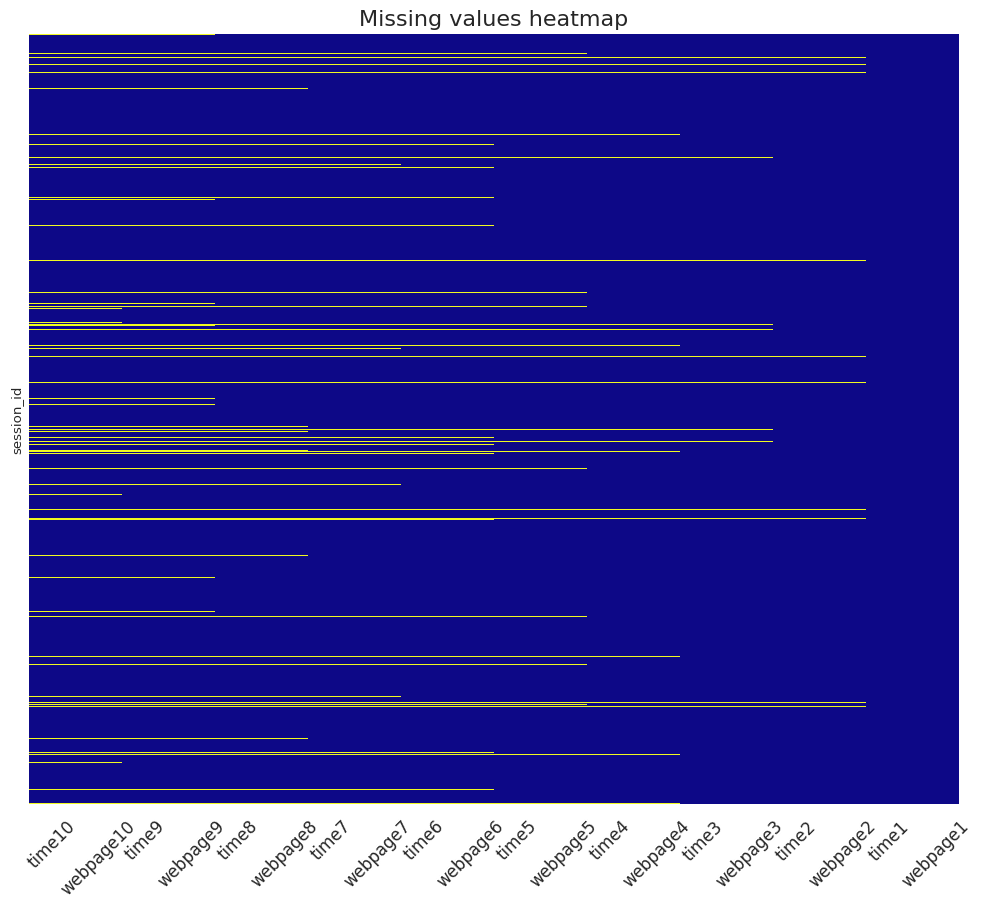

In [310]:
# Sort columns names by NaN-quantity

cols_nan_sort = list(df_train_cut.isna().sum().sort_values(ascending=False).index)

# Apply heatmap function

heatmap_missing_df(df_train_cut[cols_nan_sort])

91.2% sessions are with all 10 transitions.

In [311]:
df_train_cut.isna().sum().sort_values(ascending=False)

time10       14113
webpage10    14113
time9        12809
webpage9     12809
time8        11395
webpage8     11395
time7        10057
webpage7     10057
time6         8645
webpage6      8645
time5         7128
webpage5      7128
time4         5567
webpage4      5567
time3         3903
webpage3      3903
time2         1979
webpage2      1979
time1            0
webpage1         0
dtype: int64

.

#### 2.3.2. Heatmap for TRAIN with positive target

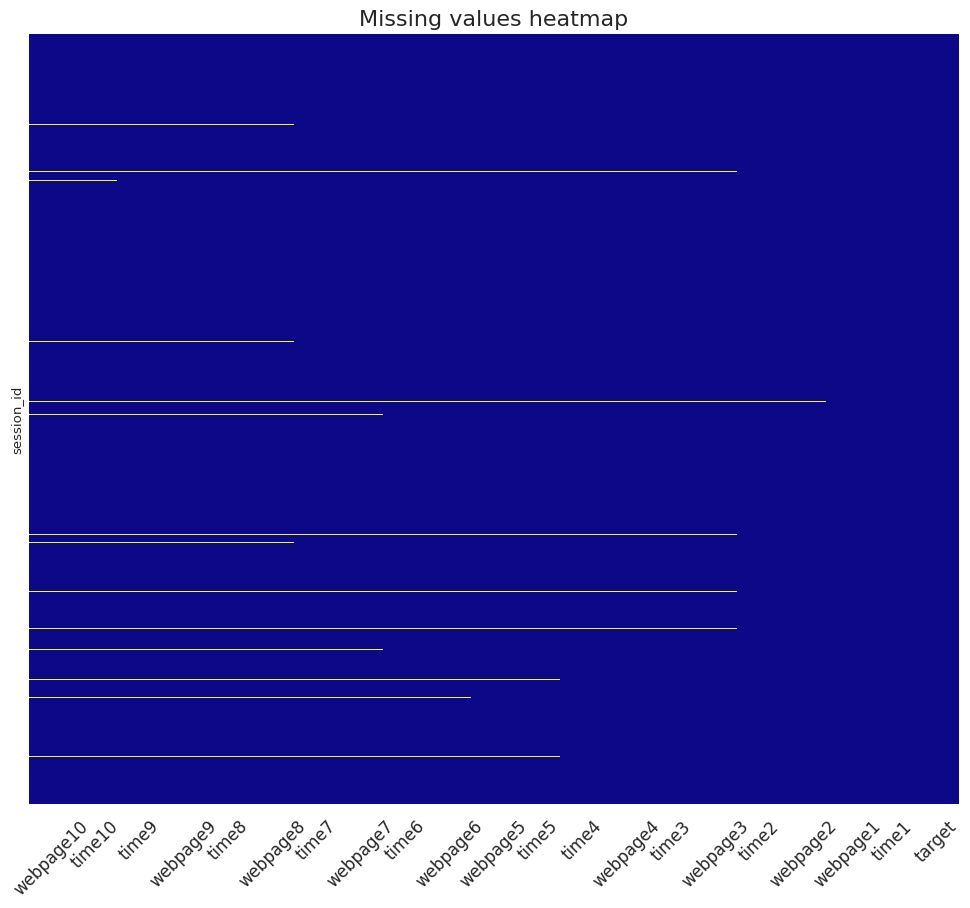

In [312]:
# Sort columns names by NaN-quantity

cols_nan_sort = list (df_train_target.isna().sum().sort_values(ascending=False).index)

# Apply heatmap function

heatmap_missing_df(df_train_target[cols_nan_sort])

98.3% sessions for TARGET=1 are with all 10 transitions.

In [313]:
df_train_target.isna().sum().sort_values(ascending=False)

webpage10    27
time10       27
time9        24
webpage9     24
time8        23
webpage8     23
time7        20
webpage7     20
time6        16
webpage6     16
webpage5     10
time5        10
time4         5
webpage4      5
time3         5
webpage3      5
time2         1
webpage2      1
webpage1      0
time1         0
target        0
dtype: int64

In [314]:
df_train_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1575 entries, 97 to 159893
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   webpage1   1575 non-null   int64         
 1   time1      1575 non-null   datetime64[ns]
 2   webpage2   1574 non-null   float64       
 3   time2      1574 non-null   datetime64[ns]
 4   webpage3   1570 non-null   float64       
 5   time3      1570 non-null   datetime64[ns]
 6   webpage4   1570 non-null   float64       
 7   time4      1570 non-null   datetime64[ns]
 8   webpage5   1565 non-null   float64       
 9   time5      1565 non-null   datetime64[ns]
 10  webpage6   1559 non-null   float64       
 11  time6      1559 non-null   datetime64[ns]
 12  webpage7   1555 non-null   float64       
 13  time7      1555 non-null   datetime64[ns]
 14  webpage8   1552 non-null   float64       
 15  time8      1552 non-null   datetime64[ns]
 16  webpage9   1551 non-null   float64     

.

### 2.4. Convert features with "timeX" into new features

#### 2.4.1. Convert only timeX

In [315]:
df_train_cut = dataset_processing(df_train_cut)

In [316]:
df_train_cut

webpage1  webpage2  webpage3  webpage4  webpage5  webpage6  \
session_id                                                               
0               9486         0         0         0         0         0   
1              11722     12385     50163     12385     12398     50150   
2             192149       659    192136    192149       633       659   
3              10591       451     77580    227821       633       425   
4                438       425       529     65685    187638       451   
...              ...       ...       ...       ...       ...       ...   
159964        117685      3935       451       828       451     30975   
159965         45314     45314      1985     31716      1530     31716   
159966        165603    165603     28947       646     28947       451   
159967         34745    195204     72458     72458     72458         0   
159968         10708      8940     10734       438       659     10708   

            webpage7  webpage8  webpage9  webpage10  duration_sec  year  \
session_id                                                                
0                  0         0         0          0      0.000000     1   
1              50163     50150     19860      19886      0.014444     1   
2             192136    192136    192136     192136      0.003889     0   
3              10591    227834    227834     227834      0.056667     1   
4                425     65685    187625     187625      0.003333     0   
...              ...       ...       ...        ...           ...   ...   
159964         30975     30975       828        828      0.008889     0   
159965         31716     31716     31716       2076      0.032778     0   
159966        330924     28947       451        425      0.001667     0   
159967             0         0         0          0      0.000000     0   
159968         10734      7562       438       7562      0.001111     0   

               month      hour  day_of_week_0  day_of_week_1  day_of_week_2  \
session_id                                                                    
0           0.090909  0.145918              0              0              1   
1           0.090909  0.224490              0              0              0   
2           1.000000  0.552041              0              0              0   
3           0.090909  0.558163              0              0              1   
4           0.272727  0.171429              0              0              0   
...              ...       ...            ...            ...            ...   
159964      0.272727  0.338776              0              0              0   
159965      0.909091  0.170408              0              0              0   
159966      0.181818  0.512245              1              0              0   
159967      0.727273  0.393878              0              0              1   
159968      1.000000  0.470408              0              0              1   

            day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
session_id                                                               
0                       0              0              0              0   
1                       0              1              0              0   
2                       0              0              0              1   
3                       0              0              0              0   
4                       1              0              0              0   
...                   ...            ...            ...            ...   
159964                  1              0              0              0   
159965                  0              0              0              1   
159966                  0              0              0              0   
159967                  0              0              0              0   
159968                  0              0              0              0   

            num_unique_pages_1  num_unique_pages_2  num_unique_pages_3  \
session_

.

#### 2.4.2. Convert timeX + split webpages into domain+suffixes (it didn't improve the results)

I want to leave only the domain + suffix of webpages instead of long names. It gives us a smaller number of webpage id's.

In [317]:
# Accurately separates a URL's subdomain, domain, and public suffix,
# using the Public Suffix List (PSL)
# https://pypi.org/project/tldextract/

links = df_id_map.webpage

df_id_map['registered_domain'] = [tldextract.extract(link).registered_domain for link in links]
df_id_map.head(10)

id                             webpage              registered_domain
0  326127              www.abmecatronique.com             abmecatronique.com
1  182113                     groups.live.com                       live.com
2  551820  majeureliguefootball.wordpress.com                  wordpress.com
3  401995           cdt46.media.tourinsoft.eu                  tourinsoft.eu
4  105504                 www.hdwallpapers.eu                hdwallpapers.eu
5  487535                img378.imageshack.us                  imageshack.us
6   71158             ecologie.nature.free.fr                        free.fr
7  460677             www.ibcn.intec.ugent.be                       ugent.be
8  392115                       kissanime.com                  kissanime.com
9  497636   www.carolineconduiteformation.com  carolineconduiteformation.com

In [318]:
df_id_map_uniq = pd.DataFrame()
df_id_map_uniq["registered_domain"] = df_id_map["registered_domain"].unique()
df_id_map_uniq.index = df_id_map_uniq.index + 1
df_id_map_uniq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20406 entries, 1 to 20406
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   registered_domain  20406 non-null  object
dtypes: object(1)
memory usage: 159.6+ KB


In [319]:
df_id_map_uniq['id2'] = df_id_map_uniq.index
df_id_map_uniq.head(10)

registered_domain  id2
1              abmecatronique.com    1
2                        live.com    2
3                   wordpress.com    3
4                   tourinsoft.eu    4
5                 hdwallpapers.eu    5
6                   imageshack.us    6
7                         free.fr    7
8                        ugent.be    8
9                   kissanime.com    9
10  carolineconduiteformation.com   10

In [320]:
web_url_df = df_id_map.merge(df_id_map_uniq, on='registered_domain', how='left')
web_url_df

id                                            webpage  \
0      326127                             www.abmecatronique.com   
1      182113                                    groups.live.com   
2      551820                 majeureliguefootball.wordpress.com   
3      401995                          cdt46.media.tourinsoft.eu   
4      105504                                www.hdwallpapers.eu   
...       ...                                                ...   
48366  386746  i1-js-14-3-01-11074-747051290-i.init.cedexis-r...   
48367  530474  i1-js-14-3-01-12434-548464295-i.init.cedexis-r...   
48368  142359                                       embed.api.tv   
48369  520516                                        n-tennis.fr   
48370  564482                               posters.tripican.com   

        registered_domain    id2  
0      abmecatronique.com      1  
1                live.com      2  
2           wordpress.com      3  
3           tourinsoft.eu      4  
4         hdwallpapers.eu      5  
...                   ...    ...  
48366   cedexis-radar.net     20  
48367   cedexis-radar.net     20  
48368              api.tv  20405  
48369         n-tennis.fr  20406  
48370        tripican.com  18697  

[48371 rows x 4 columns]

In [321]:
web_url_ids = pd.DataFrame()
web_url_ids['id1'] = web_url_df['id']
web_url_ids['webpage1'] = web_url_df['id2']
web_url_ids

id1  webpage1
0      326127         1
1      182113         2
2      551820         3
3      401995         4
4      105504         5
...       ...       ...
48366  386746        20
48367  530474        20
48368  142359     20405
48369  520516     20406
48370  564482     18697

[48371 rows x 2 columns]

In [322]:
# df_t = df_train.copy(deep=True)
df_train_cut_dom_suf  = df_train.drop(columns='target') # for testing to reduse a number of webpage id's

for i in range(10): df_train_cut_dom_suf.rename(columns={f'webpage{i+1}': f'id{i+1}'},
                                                inplace=True)

for i in range(10):
    web_url_ids = pd.DataFrame()
    web_url_ids[f'id{i+1}'] = web_url_df['id']
    web_url_ids[f'webpage{i+1}'] = web_url_df['id2']
    df_train_cut_dom_suf = df_train_cut_dom_suf.merge(web_url_ids,
                                                      on=f'id{i+1}',
                                                      how='left')
    df_train_cut_dom_suf = df_train_cut_dom_suf.drop(columns=f'id{i+1}')

In [323]:
df_train_cut_dom_suf = dataset_processing(df_train_cut_dom_suf)
df_train_cut_dom_suf

webpage1  webpage2  webpage3  webpage4  webpage5  webpage6  webpage7  \
0            171         0         0         0         0         0         0   
1            128       128       128       128       128       128       128   
2           3463       128      3463      3463      2105       128      3463   
3            128       128      2105      5030      2105      3351       128   
4            128      3351       863      6938      6691       128      3351   
...          ...       ...       ...       ...       ...       ...       ...   
159964     12318      1284       128       128       128      4214      4214   
159965        23        23       601       280      2615       280       280   
159966      1320      1320      9515      3463      9515       128      9515   
159967      7806       885      9543      9543      9543         0         0   
159968       128      5384       128       128       128       128       128   

        webpage8  webpage9  webpage10  duration_sec  year     month      hour  \
0              0         0          0      0.000000     1  0.090909  0.145918   
1            128       805        805      0.014444     1  0.090909  0.224490   
2           3463      3463       3463      0.003889     0  1.000000  0.552041   
3           3105      3105       3105      0.056667     1  0.090909  0.558163   
4           6938      6938       6938      0.003333     0  0.272727  0.171429   
...          ...       ...        ...           ...   ...       ...       ...   
159964      4214       128        128      0.008889     0  0.272727  0.338776   
159965       280       280       1033      0.032778     0  0.909091  0.170408   
159966      9515       128       3351      0.001667     0  0.181818  0.512245   
159967         0         0          0      0.000000     0  0.727273  0.393878   
159968       128       128        128      0.001111     0  1.000000  0.470408   

        day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
0                   0              0              1              0   
1                   0              0              0              0   
2                   0              0              0              0   
3                   0              0              1              0   
4                   0              0              0              1   
...               ...            ...            ...            ...   
159964              0              0              0              1   
159965              0              0              0              0   
159966              1              0              0              0   
159967              0              0              1              0   
159968              0              0              1              0   

        day_of_week_4  day_of_week_5  day_of_week_6  num_unique_pages_1  \
0                   0              0              0                   1   
1                   1              0              0                   0   
2                   0              0              1                   0   
3                   0              0              0                   0   
4                   0              0              0                   0   
...               ...            ...            ...                 ...   
159964              0              0              0                   0   
159965              0              0              1                   0   
159966              0              0              0                   0   
159967              0              0              0                   0   
159968              0              0              0                   0   

        num_unique_pages_2  num_unique_pages_3  num_unique_pages_4  \
0                        0                   0                   0   
1                        1                   0                   0   
2                        0                   1                   0   
3                        0                   0      

In [324]:
for i in range(10):
    print(df_train_cut[f'webpage{i+1}'].nunique())

11565
11531
11562
11554
11575
11555
11535
11575
11539
11510


In [325]:
for i in range(10):
    print(df_train_cut_dom_suf[f'webpage{i+1}'].nunique())

5987
5974
6021
6048
5962
6010
5991
6079
5943
5963


Quantity of unique webpages encreased in 2 times, that may simplify calculations. Results see in p.4.4.

.

# **3. EDA**

### 3.1. Target EDA

In [326]:
fig = px.histogram(target,
                   x = "target",
                   text_auto = True,
                   width = 600,
                   height = 500,
                   title = 'Target count (0 and 1)')
fig.update_layout(bargap = 0.2)
fig.show()

Target = 1 is only 1% from all target values. It's a strongly imbalanced feature. Requires stratification in data processing.

.

### 3.2. Count month sessions - train datasets

In [327]:
fig = px.histogram(df_train,
                   x = "time1",
                   text_auto = True,
                   width = 800,
                   height = 500,
                   title = 'First time session - count by months of years (TRAIN)',
                   nbins = 26)
fig.update_layout(bargap = 0.2)
fig.show()

Train dataset. Total period is 14 months. The main observed activity is in the last four months from Novemver 2018 to February 2019.

In [328]:
fig = px.histogram(df_train[df_train['target'] == 1],
                   x = "time1",
                   text_auto = True,
                   width = 800,
                   height = 500,
                   title = 'First time session - count by months of years (TRAIN with TARGET=1)',
                   nbins = 13)
fig.update_layout(bargap = 0.2)
fig.show()

Target person has similar activity like all the rest in train dataset + September 2018.

.

### 3.3. Count days of week

In [329]:
fig = px.histogram(df_train,
                   x = df_train["time1"].dt.dayofweek,
                   text_auto = True,
                   width = 800,
                   height = 500,
                   title = 'First time session - count by DAYS of WEEK (TRAIN)',
                   nbins = 7)
fig.update_layout(bargap = 0.2)
fig.show()

Legend 0-6: Monday-Sunday

A smooth decrease in activity from Monday to Saturday and a slight peak on Sunday.

In [330]:
fig = px.histogram(df_train,
                   x = df_train[df_train['target'] == 1]['time1'].dt.dayofweek,
                   text_auto = True,
                   width = 800,
                   height = 500,
                   title = 'First time session - count by DAYS of WEEK (TARGET=1)',
                   nbins = 7)
fig.update_layout(bargap = 0.2)
fig.show()

Legend 0-6: Monday-Sunday

The activity of the target does not have any clear trend.

.

### 3.4. Correlation

<ipython-input-331-1b593843d3c7>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-331-1b593843d3c7>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



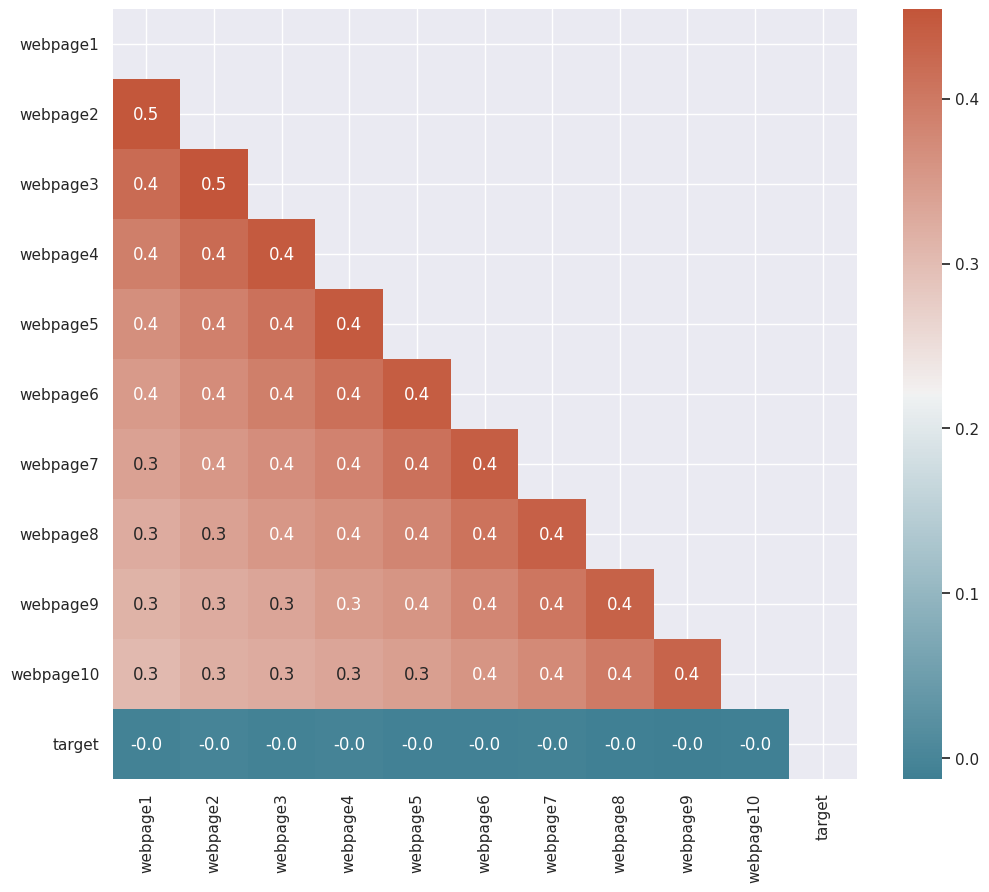

In [331]:
sns.set_theme()

plt.figure(figsize=(12,10))
matrix = np.triu(df_train.corr(method='spearman'))
sns.heatmap(df_train.corr(method='spearman'),
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
            annot=True,
            mask=matrix,
            fmt='.1f')
plt.show()

There is no high correlation between webpages.

.

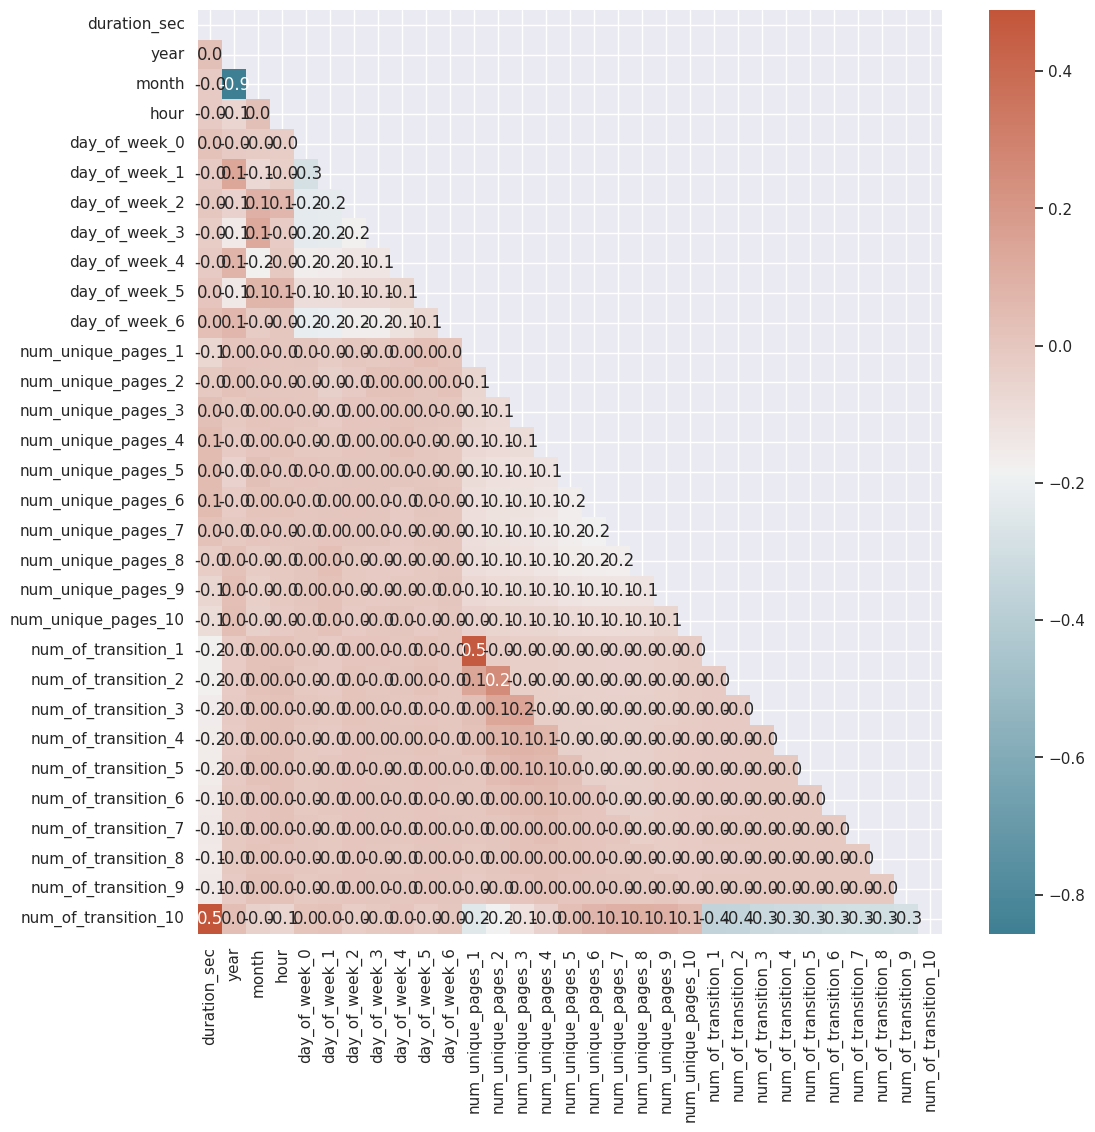

In [332]:
cols_nowebpages = ['webpage1', 'webpage2', 'webpage3', 'webpage4',
                   'webpage5', 'webpage6', 'webpage7', 'webpage8',
                   'webpage9', 'webpage10']
# for col in cols_nowebpages: df_train_nowebpages = df_train_cut.drop(col)
df_train_nowebpages = df_train_cut.copy(deep=True)
#df_train_nowebpages = df_train_cut[cols_nowebpages]
for col in cols_nowebpages: df_train_nowebpages = df_train_nowebpages.drop([col], axis=1)

sns.set_theme()

plt.figure(figsize=(12,12))
matrix = np.triu(df_train_nowebpages.corr(method='spearman'))
sns.heatmap(df_train_nowebpages.corr(method='spearman'),
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
            annot=True,
            mask=matrix,
            fmt='.1f')
plt.show()

Only 'month' and 'year' have high correlation = 0.9, besause the main number of sessions were in 2019 year.

.

# **4. Model comparison**

### 4.1. Splitting on train 80/20 with stratify

In [333]:
X_train, X_val, y_train, y_val = train_test_split(df_train_cut,
                                                  target,
                                                  test_size=0.20,
                                                  stratify=target,
                                                  shuffle=True,
                                                  random_state=22)

.

### 4.2. Load models

Apply the following models:
- LogisticRegression
- GaussianNB
- DecisionTreeClassifier
- RandomForestClassifier
- XGBClassifier
- LGBMClassifier
- CatBoostClassifier


In [334]:
lr = LogisticRegression(solver='lbfgs',
                        max_iter=1000,
                        class_weight='balanced',
                        random_state=22)
gnb = GaussianNB()

dt = DecisionTreeClassifier(max_depth=7,
                            class_weight = 'balanced',
                            random_state = 22)

rf = RandomForestClassifier(n_estimators=100,
                            class_weight = 'balanced',
                            random_state = 22)

xgb = XGBClassifier(objective ='binary:logistic',
                    random_state = 22)

lgbm = LGBMClassifier(n_estimators=1000,
                      class_weight = 'balanced',
                      random_state = 22)

catb = CatBoostClassifier(verbose=False,
                          random_state = 22)

.

### 4.3. Apply models and classification report

In [335]:
y_pred_pr_lr, y_pred_lr = fit_pred_aucroc(X_train, y_train, X_val, y_val, lr)

Model: lr
ROC_AUC: 0.5012084015398515

REPORT:
               precision    recall  f1-score   support

           0    0.88576   0.98963   0.93482     28354
           1    0.06667   0.00577   0.01062      3640

    accuracy                        0.87770     31994
   macro avg    0.47621   0.49770   0.47272     31994
weighted avg    0.79257   0.87770   0.82967     31994



In [336]:
y_pred_pr_gnb, y_pred_gnb = fit_pred_aucroc(X_train, y_train, X_val, y_val, gnb)

Model: gnb
ROC_AUC: 0.6013064585873071

REPORT:
               precision    recall  f1-score   support

           0    1.00000   0.99015   0.99505     31994
           1    0.00000   0.00000   0.00000         0

    accuracy                        0.99015     31994
   macro avg    0.50000   0.49508   0.49753     31994
weighted avg    1.00000   0.99015   0.99505     31994



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [337]:
y_pred_pr_dt, y_pred_dt = fit_pred_aucroc(X_train, y_train, X_val, y_val, dt)

Model: dt
ROC_AUC: 0.9445574330198213

REPORT:
               precision    recall  f1-score   support

           0    0.90205   0.99965   0.94834     28586
           1    0.96825   0.08950   0.16385      3408

    accuracy                        0.90270     31994
   macro avg    0.93515   0.54457   0.55610     31994
weighted avg    0.90910   0.90270   0.86478     31994



In [338]:
y_pred_pr_rf, y_pred_rf = fit_pred_aucroc(X_train, y_train, X_val, y_val, rf)

Model: rf
ROC_AUC: 0.9841077435004011

REPORT:
               precision    recall  f1-score   support

           0    0.99984   0.99373   0.99677     31874
           1    0.36508   0.95833   0.52874       120

    accuracy                        0.99359     31994
   macro avg    0.68246   0.97603   0.76275     31994
weighted avg    0.99746   0.99359   0.99502     31994



In [339]:
y_pred_pr_xgb, y_pred_xgb = fit_pred_aucroc(X_train, y_train, X_val, y_val, xgb)

Model: xgb
ROC_AUC: 0.9945030932814638

REPORT:
               precision    recall  f1-score   support

           0    0.99937   0.99585   0.99761     31791
           1    0.58095   0.90148   0.70656       203

    accuracy                        0.99525     31994
   macro avg    0.79016   0.94866   0.85208     31994
weighted avg    0.99671   0.99525   0.99576     31994



In [340]:
y_pred_pr_lgbm, y_pred_lgbm = fit_pred_aucroc(X_train, y_train, X_val, y_val, lgbm)

[LightGBM] [Info] Number of positive: 1260, number of negative: 126715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 127975, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Model: lgbm
ROC_AUC: 0.9966316878088083

REPORT:
               precision    recall  f1-score   support

           0    0.99880   0.99789   0.99834     31708
           1    0.78730   0.86713   0.82529       286

    accuracy                        0.99672     31994
   macro avg    0.89305   0.93251   0.91182     31994
weighted avg    0.99691   0.99672   0.99680     31994



In [341]:
y_pred_pr_catb, y_pred_catb = fit_pred_aucroc(X_train, y_train, X_val, y_val, catb)

Model: catb
ROC_AUC: 0.9963451828535954

REPORT:
               precision    recall  f1-score   support

           0    0.99965   0.99582   0.99773     31801
           1    0.57778   0.94301   0.71654       193

    accuracy                        0.99550     31994
   macro avg    0.78872   0.96941   0.85713     31994
weighted avg    0.99711   0.99550   0.99604     31994



.

### 4.4. Model for splitted domain+suffix

In [342]:
X_train_ds, X_val_ds, y_train_ds, y_val_ds = train_test_split(df_train_cut_dom_suf,
                                                              target,
                                                              test_size = 0.20,
                                                              stratify=target,
                                                              shuffle = True,
                                                              random_state=22)

lgbm_dom_suf = LGBMClassifier(n_estimators=1000,
                              class_weight = 'balanced',
                              random_state = 22)

y_pred_pr_lgbm_dom_suf, y_pred_lgbm_dom_suf = fit_pred_aucroc(X_train_ds,
                                                              y_train_ds,
                                                              X_val_ds,
                                                              y_val_ds,
                                                              lgbm_dom_suf)


[LightGBM] [Info] Number of positive: 1260, number of negative: 126715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 127975, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Model: lgbm_dom_suf
ROC_AUC: 0.9915824763989163

REPORT:
               precision    recall  f1-score   support

           0    0.99830   0.99716   0.99773     31715
           1    0.71429   0.80645   0.75758       279

    accuracy                        0.99550     31994
   macro avg    0.85629   0.90181   0.87765     31994
weighted avg    0.99582   0.99550   0.99563     31994



Unfortunattely the idea to decrease a quantity of webpages by splitting only domain+suffix (in p.2.4.2) didn't help to make the score better.

.

### 4.5. ROC-curves

Let's consider ROC-curve for all models

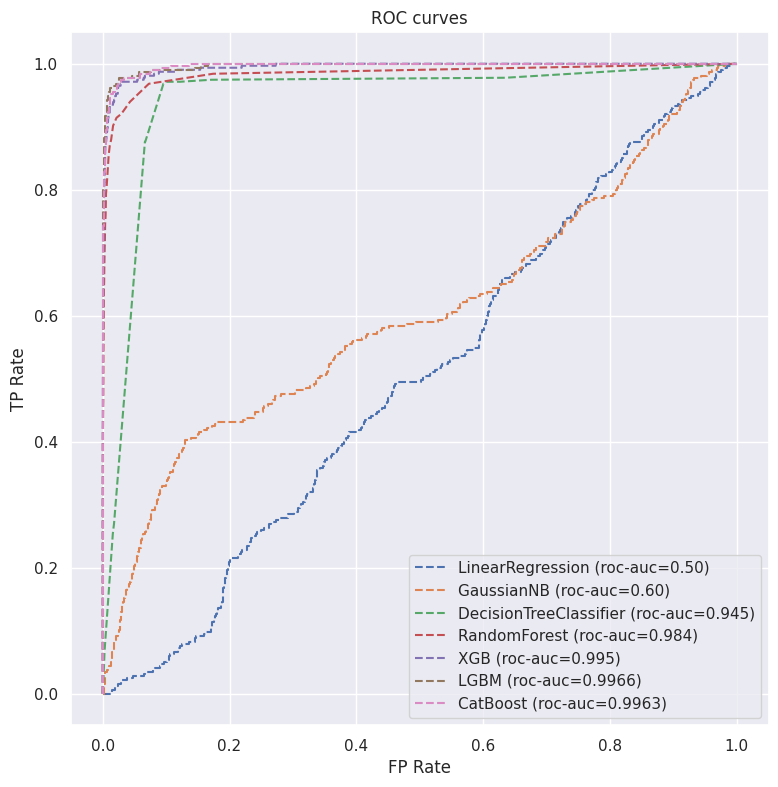

In [343]:
# Visualization of AUC_ROC for mentioned models

lr_fpr, lr_tpr, threshold = roc_curve(y_val, y_pred_pr_lr)
auc_lr = roc_auc_curve_value(lr_fpr, lr_tpr, 'lr')

gnb_fpr, gnb_tpr, threshold = roc_curve(y_val, y_pred_pr_gnb)
auc_gnb = roc_auc_curve_value(gnb_fpr, gnb_tpr, 'gnb')

dt_fpr, dt_tpr, threshold = roc_curve(y_val, y_pred_pr_dt)
auc_dt = roc_auc_curve_value(dt_fpr, dt_tpr, 'dt')

rf_fpr, rf_tpr, threshold = roc_curve(y_val, y_pred_pr_rf)
auc_rf = roc_auc_curve_value(rf_fpr, rf_tpr, 'rf')

xgb_fpr, xgb_tpr, threshold = roc_curve(y_val, y_pred_pr_xgb)
auc_xgb = roc_auc_curve_value(xgb_fpr, xgb_tpr, 'xgb')

lgbm_fpr, lgbm_tpr, threshold = roc_curve(y_val, y_pred_pr_lgbm)
auc_lgbm = roc_auc_curve_value(lgbm_fpr, lgbm_tpr, 'lgbm')

catb_fpr, catb_tpr, threshold = roc_curve(y_val, y_pred_pr_catb)
auc_catb = roc_auc_curve_value(catb_fpr, catb_tpr, 'catb')

plt.figure(figsize=(9,9), dpi=100)

plt.plot(lr_fpr, lr_tpr, linestyle='--', label = f"LinearRegression (roc-auc={auc_lr:.2f})")
plt.plot(gnb_fpr, gnb_tpr, linestyle='--', label = f"GaussianNB (roc-auc={auc_gnb:.2f})")
plt.plot(dt_fpr, dt_tpr, linestyle='--', label = f"DecisionTreeClassifier (roc-auc={auc_dt:.3f})")
plt.plot(rf_fpr, rf_tpr, linestyle='--', label = f"RandomForest (roc-auc={auc_rf:.3f})")
plt.plot(xgb_fpr, xgb_tpr, linestyle='--', label = f"XGB (roc-auc={auc_xgb:.3f})")
plt.plot(lgbm_fpr, lgbm_tpr, linestyle='--', label = f"LGBM (roc-auc={auc_lgbm:.4f})")
plt.plot(catb_fpr, catb_tpr, linestyle='--', label = f"CatBoost (roc-auc={auc_catb:.4f})")
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC curves')
plt.legend()
plt.show()

LGBM and CatBoost have the highest roc-auc-metric

.

### 4.6. Confusion matrix

Let's consider Confusion Matrix for 2 best models

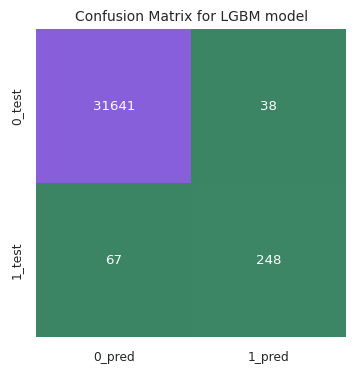

In [344]:
conf_matr_plot(y_val, y_pred_lgbm, 'LGBM')

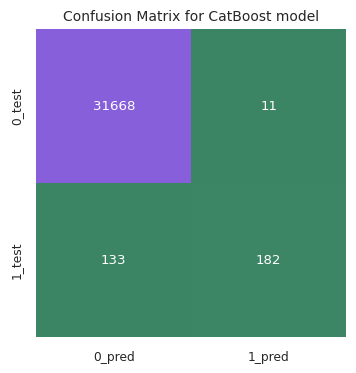

In [345]:
conf_matr_plot(y_val, y_pred_catb, 'CatBoost')

LGBM model shows better result than CatBoost.

.

### 4.7. Hyperparameters for LGBM model

#### 4.7.1. Hyperparameters for "boosting_type": 'gbdt' and 'goss'

Choose "f1_weighted"-metric as combination os precission and recall metrics

In [346]:
# cv = KFold(n_splits = 5, shuffle = True, random_state = 22)
# grid = {"boosting_type": ['gbdt'],
#           "n_estimators": range(500,1500, 100)}

# gs = (GridSearchCV(lgbm,
#                          grid,
#                          scoring='f1_weighted',    # https://scikit-learn.org/stable/modules/model_evaluation.html
#                          n_jobs=-1,
#                          cv=cv))

# search = gs.fit(X_train, y_train)

# print("Hyperparameters:\n")
# print(search.best_params_)

In [347]:
# cv = KFold(n_splits = 5, shuffle = True, random_state = 22)
# grid = {"boosting_type": ['goss'],
#           "n_estimators": range(500,1500, 100)}

# gs = (GridSearchCV(lgbm,
#                          grid,
#                          scoring='f1_weighted',
#                          n_jobs=-1,
#                          cv=cv))

# search = gs.fit(X_train, y_train)

# print("Hyperparameters:\n")
# print(search.best_params_)

{'boosting_type': 'gbdt', 'n_estimators': 800}

{'boosting_type': 'goss', 'n_estimators': 700}

.

#### 4.7.2. Classification report and Confusion matrix (GOSS)

In [348]:
lgbm3 = LGBMClassifier(n_estimators=700,
                       # boosting_type = 'goss',
                       class_weight = 'balanced',
                       random_state = 22,
                       **{"data_sample_strategy": "goss"})

In [349]:
y_pred_pr_lgbm3, y_pred_lgbm3 = fit_pred_aucroc(X_train,
                                                y_train,
                                                X_val,
                                                y_val,
                                                lgbm3)

[LightGBM] [Info] Number of positive: 1260, number of negative: 126715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 127975, number of used features: 41
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Model: lgbm3
ROC_AUC: 0.9964114227190713

REPORT:
               precision    recall  f1-score   support

           0    0.99836   0.99826   0.99831     31682
           1    0.82540   0.83333   0.82935       312

    accuracy                        0.99666     31994
   macro avg    0.91188   0.91580   0.91383     31994
weighted avg    0.99667   0.99666   0.99666     31994



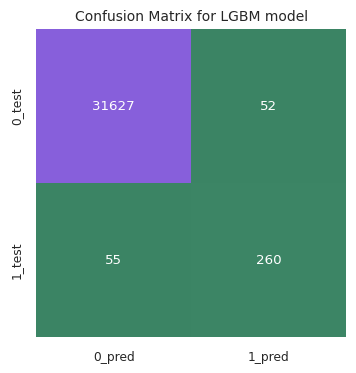

In [350]:
conf_matr_plot(y_val, y_pred_lgbm3, 'LGBM')

And now compare with GBDT below

.

#### 4.7.3. Classification report and Confusion matrix (GBDT)

In [351]:
lgbm2 = LGBMClassifier(n_estimators=800,
                       boosting_type = 'gbdt',
                       class_weight = 'balanced',
                       random_state = 22)

In [352]:
y_pred_pr_lgbm2, y_pred_lgbm2 = fit_pred_aucroc(X_train,
                                                y_train,
                                                X_val,
                                                y_val,
                                                lgbm2)

[LightGBM] [Info] Number of positive: 1260, number of negative: 126715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 127975, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Model: lgbm2
ROC_AUC: 0.9965509172617982

REPORT:
               precision    recall  f1-score   support

           0    0.99855   0.99808   0.99831     31694
           1    0.80635   0.84667   0.82602       300

    accuracy                        0.99666     31994
   macro avg    0.90245   0.92237   0.91216     31994
weighted avg    0.99675   0.99666   0.99670     31994



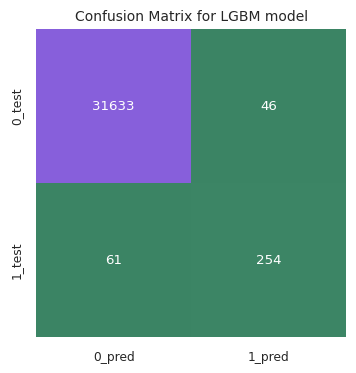

In [353]:
conf_matr_plot(y_val, y_pred_lgbm2, 'LGBM')

Choose LGBMClassifier with parameters, but previous boosting_type is a very similar:
- n_estimators=800
- boosting_type = 'gbdt'
- class_weight = 'balanced'
- random_state = 22

.

### 4.8. Results of models

In [354]:
roc_auc_table

model_name   roc_auc
0         lr  0.501208
1        gnb  0.601306
2         dt  0.944557
3         rf  0.984108
4        xgb  0.994503
5       lgbm  0.996632
6       catb  0.996345

In [355]:
conf_matr_table

model_name        TP        TN
0       LGBM  0.997887  0.867133
1   CatBoost  0.995818  0.943005
2       LGBM  0.998264  0.833333
3       LGBM  0.998075  0.846667

.

# **5. Apply final model test_submit**

In [356]:
fileDownloaded = drive.CreateFile({'id':'1p5fGmVzs8RA27zFUpeVDVX0xT_GD0_qr'})
fileDownloaded.GetContentFile('test.csv')
df_test = pd.read_csv('test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

pd.set_option('display.max_columns', None)
df_test.head()

webpage1               time1  webpage2               time2  \
session_id                                                               
0              10318 2019-03-28 06:47:12   10318.0 2019-03-28 06:47:42   
1                438 2019-02-28 06:48:05    2453.0 2019-02-28 06:50:22   
2               7562 2019-03-18 11:13:31     425.0 2019-03-18 11:13:39   
3               8836 2019-03-17 12:18:08   12372.0 2019-03-17 12:18:35   
4                451 2019-03-31 09:46:43    9863.0 2019-03-31 09:46:44   

            webpage3               time3  webpage4               time4  \
session_id                                                               
0            10318.0 2019-03-28 06:48:12   10318.0 2019-03-28 06:48:42   
1             2427.0 2019-02-28 06:50:22    2466.0 2019-02-28 06:50:23   
2             7562.0 2019-03-18 11:18:02     425.0 2019-03-18 11:18:43   
3            12398.0 2019-03-17 12:18:35   12385.0 2019-03-17 12:18:35   
4              451.0 2019-03-31 09:46:46    9889.0 2019-03-31 09:46:46   

            webpage5               time5  webpage6               time6  \
session_id                                                               
0            10318.0 2019-03-28 06:49:12   10318.0 2019-03-28 06:49:42   
1             2453.0 2019-02-28 06:50:23    2466.0 2019-02-28 06:50:59   
2              425.0 2019-03-18 11:24:57       NaN                 NaT   
3            12385.0 2019-03-17 12:18:36   12398.0 2019-03-17 12:18:36   
4              451.0 2019-03-31 09:47:45     425.0 2019-03-31 09:47:46   

            webpage7               time7  webpage8               time8  \
session_id                                                               
0            10318.0 2019-03-28 06:50:12   10318.0 2019-03-28 06:50:42   
1             2427.0 2019-02-28 06:50:59    2453.0 2019-02-28 06:50:59   
2                NaN                 NaT       NaN                 NaT   
3            12372.0 2019-03-17 12:18:36     451.0 2019-03-17 12:18:52   
4             9928.0 2019-03-31 09:49:43     867.0 2019-03-31 10:05:12   

            webpage9               time9  webpage10              time10  
session_id                                                               
0            10318.0 2019-03-28 06:51:12    10318.0 2019-03-28 06:51:42  
1             2453.0 2019-02-28 06:52:06     2466.0 2019-02-28 06:52:11  
2                NaN                 NaT        NaN                 NaT  
3              425.0 2019-03-17 12:18:52      438.0 2019-03-17 12:18:53  
4              880.0 2019-03-31 10:05:12      867.0 2019-03-31 10:05:13

In [357]:
df_train_cut2 = df_train.drop(columns='target')
# df_test2 = df_test
target = df_train.target

df_train_cut2 = dataset_processing(df_train_cut2)
df_test = dataset_processing(df_test)

df_train_cut2.shape, df_test.shape

((159969, 41), (93338, 41))

In [358]:
lgbm = LGBMClassifier(boosting_type = 'gbdt',
                      n_estimators=800,
                      random_state = 22)
lgbm.fit(df_train_cut2,
         target)
roc_auc_score_lgbm = roc_auc_score(target,
                                   lgbm.predict_proba(df_train_cut2)[:, 1])
# print(roc_auc_score_lgbm)

[LightGBM] [Info] Number of positive: 1575, number of negative: 158394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 159969, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009846 -> initscore=-4.610830
[LightGBM] [Info] Start training from score -4.610830


In [359]:
pred_test = lgbm.predict_proba(df_test)[:, 1]

test_submit = pd.Series(pred_test,
                        name='target',
                        index=pd.Index(range(len(pred_test)),
                                       name='session_id'))
test_submit

session_id
0        5.741399e-10
1        6.978644e-10
2        1.911321e-05
3        9.456454e-04
4        4.618597e-09
             ...     
93333    8.915154e-08
93334    6.614298e-11
93335    6.893612e-11
93336    7.653291e-06
93337    8.194902e-10
Name: target, Length: 93338, dtype: float64

In [360]:
# def create_download_link(df, title = "Download CSV file", filename = "test_submit.csv"):
#     csv = df.to_csv()
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

# ## Create a link for submited CSV file
# create_download_link(test_submit)

.

# **6. Conclusions**

1. Created new features:
- duration of all session
- nr of unique webpages
- nr of transition
- year
- month
- hour
- day of week

.

2. OneHotEncoding was applied to features:
- nr of unique webpages
- nr of transition
- day of week

.

3. All features was normalized in (0, 1) because all feature values can't be negative. But normalizing of webpages ids didn't help to encrease score.

.

4. There was an attempt to apply additional information about webpages from file "id_map.parquet", but this did not improve the accuracy of the metrics (p.2.4.2 and p.4.4)

.


5. Target with 1 - is only 1% from all target values. It's a strongly imbalanced feature.

.

6. Models for predicion:
- LogisticRegression
- GaussianNB
- DecisionTreeClassifier
- RandomForestClassifier
- XGBClassifier
- LGBMClassifier
- CatBoostClassifier

.

7. Metrics for analisis:
- ROC-AUC
- ROC-curve
- Confusion matrix

.

8. ROC-AUC values are:
- LinearRegression = 0.50
- GaussianNB = 0.60
- DecisionTreeClassifier = 0.945
- RandomForest = 0.984
- XGB = 0.969
- LGBM = 0.9964
- CatBoost = 0.9963

.

9. The best results were showed by LGBMClassifier with parameters (after comparing confusion matrixes and tuning):
- n_estimators=800
- boosting_type = 'gbdt'
- class_weight = 'balanced'
- random_state = 22

.

10. "Run all" successfully checked in the notebook - during 35 minutes. Therefore, I commented out the hyperparameters - this is the main time.

.

11. How to improve result?
- Try to apply NLTK to names of webpages.
- Try to apply NLTK to rows with webpage sessions.




.